In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import vsm
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans les colonnes du dataframe

In [3]:
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-1]) #remonter au dossier root du projet
os.chdir(path_root)
path = PureWindowsPath(os.getcwd() + "/data/input/data.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"

zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class, random_state=42)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

(1825, 6)
1    1825
0    1825
Name: category_bin, dtype: int64
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,"_Ainsi donc, si l’on comprend avec S. Hilaire qu’il demanda ainsi que les autres martyrs deviennent les imitateurs de sa passion; ou qu’il demanda de ne pas être bouleversé par la crainte de boire la coupe; ou de ne pas être retenu par la mort, on peut dire que sa prière fut entièrement exaucée._",ainsi donc si comprend hilaire demanda ainsi autres martyr deviennent imitateur passion demanda être bouleversé crainte boire coupe être retenu mort peut dire prière entièrement exaucée,philosophy,300,1
1,1,"> **En sens contraire,** pour l’esprit, le genre précède ce qui est contenu > dans ce genre. Mais rien n’est antérieur à Dieu, ni dans la réalité, ni pour > l’esprit. Dieu n’est donc pas un genre. -Ia, Q3, a5",sens contraire esprit genre précède contenu genre rien antérieur dieu ni réalité ni esprit dieu donc genre -ia q a,philosophy,210,1
...,...,...,...,...,...,...
3648,3648,"Pour ces raisons, les réformés ne donnent la Cène qu’à des enfants qui peuvent aussi discerner le corps, faire ceci en mémoire de Christ, manger du solide, boire du vin, s’examiner. Donc pas à des tout-petits. Certaines églises réformées placent de façon illégitime des limites d’âge, souvent élevées (19 ans), à ce sujet[3]. Je pense toutefois que déjà assez jeune, un enfant peut être capable de comprendre les grandes lignes de ce que signifie la Cène. Calvin donne l’exemple d’un enfant de dix ans[4].",raison réformé donnent cène enfant peuvent aussi discerner corps faire ceci mémoire christ manger solide boire vin examiner donc tout-petit certaines église réformées placent façon illégitime limite âge souvent élevées an sujet pense toutefois déjà assez jeune enfant peut être capable comprendre grand ligne signifie cène calvin donne exemple enfant dix an,baptism,511,0
3649,3649,"A ma connaissance, personne, en premier Jésus, car tout repose sur lui, n’a jamais dit: baptisez les enfants. Jésus dira: laissez venir à moi les petits enfants, par exemple. Si réellement, il avait souhaité qu’ils soient baptisés, c’est certainement le moment qu’il aurait choisi pour en parler.",a connaissance personne premier jésus car tout repose a jamais dit baptisez enfant jésus dira laissez venir petit enfant exemple si réellement souhaité baptisé certainement moment choisi parler,baptism,299,0


In [6]:
X = corpus["message_preprocessed"]
y = corpus["category"]
# y = corpus["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# X_train = X_train.iloc[0:500]

In [7]:
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

hashing_vectorizer = HashingVectorizer()
X_train_hashing = hashing_vectorizer.fit_transform(X_train)

X_train_observed_expected = vsm.observed_over_expected(X_train_count).round(2)
# X_train_observed_expected = np.ravel(X_train_observed_expected)
# X_train_observed_expected = np.delete(X_train_observed_expected, np.where(X_train_observed_expected == 0))

X_train_pmi = vsm.pmi(X_train_count)


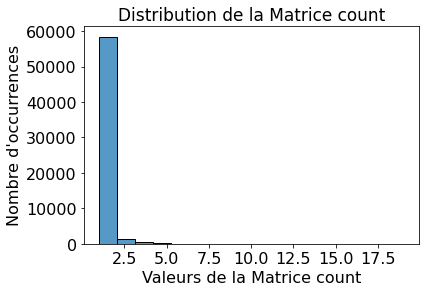

In [8]:
# Distribution des valeurs de la matrice count
path = PureWindowsPath(os.getcwd() + "\\data\\output\\count_matrix_distribution.png")
path = path.as_posix()

sb.histplot(X_train_count.data)
plt.xlabel("Valeurs de la Matrice count", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la Matrice count", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.savefig(path)
plt.show()

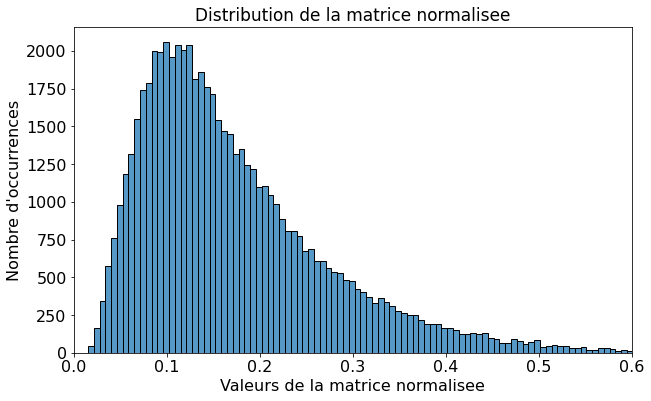

In [9]:
# Distribution des valeurs de la matrice normalization
from sklearn.preprocessing import normalize
X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne

path = PureWindowsPath(os.getcwd() + "\\data\\output\\normalization_distribution.png")
path = path.as_posix()

sb.histplot(X_train_tfidf.data, edgecolor="black", linewidth=1)
plt.xlabel("Valeurs de la matrice normalisee", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice normalisee", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

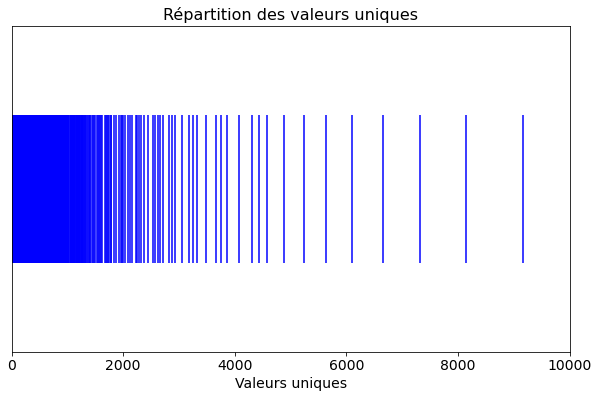

In [10]:
# Graphique avec barres en 1D des valeurs uniques (pour voir comment elles sont reparties, que a droite ?, que a gauche ?, etc.)
# sb.scatterplot(x=X_tfidf_unique, y=np.zeros_like(X_tfidf_unique), sizes=(10000,10000))
path = PureWindowsPath(os.getcwd() + "\\data\\output\\observed_expected_matrix_unique_distribution.png")
path = path.as_posix()

plt.figure()
plt.hlines(0,0,1)  # Draw a horizontal line
plt.eventplot(np.unique(X_train_observed_expected), orientation='horizontal', colors='b')
plt.xlabel("Valeurs uniques", size=14)
plt.title("Répartition des valeurs uniques", size=16)
plt.xticks(fontsize=14)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.rcParams["figure.figsize"] = (9, 4)
plt.xlim(0, 10000)
plt.savefig(path)
plt.show()

In [12]:
import plotly.express as px
fig = px.histogram(X_train_observed_expected[X_train_observed_expected != 0])
fig.update_traces(marker_line_width=1, marker_line_color="white")
fig.show()

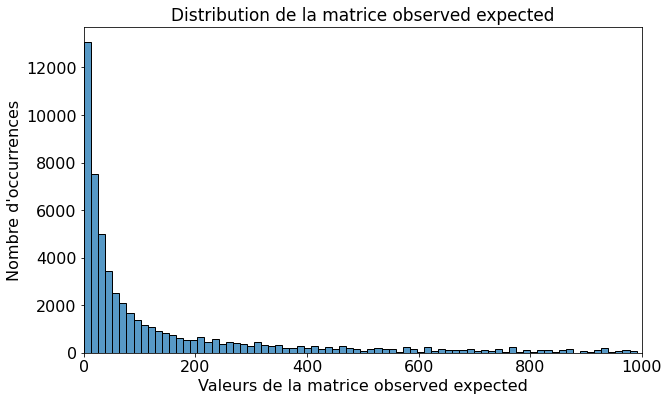

In [20]:
# Distribution des valeurs de la matrice observed expected
path = PureWindowsPath(os.getcwd() + "\\data\\output\\observed_expected_matrix_distribution.png")
path = path.as_posix()

sb.histplot(np.ravel(X_train_observed_expected[X_train_observed_expected != 0]), edgecolor="black", linewidth=1)
plt.xlabel("Valeurs de la matrice observed expected", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice observed expected", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 1000)
plt.savefig(path)
plt.show()

In [17]:
X_train_pmi[X_train_pmi != 0].shape

(1, 60517)

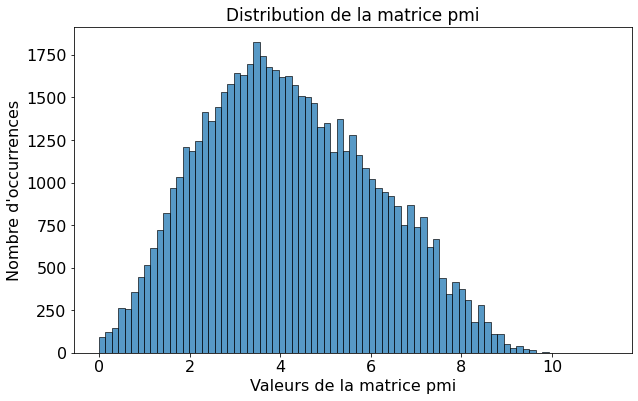

In [19]:
# Distribution des valeurs de la matrice X_train_pmi
path = PureWindowsPath(os.getcwd() + "\\data\\output\\pmi_matrix_distribution.png")
path = path.as_posix()

# sb.histplot(X_train_pmi[X_train_pmi != 0])
sb.histplot(np.ravel(X_train_pmi[X_train_pmi != 0]))
plt.xlabel("Valeurs de la matrice pmi", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice pmi", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.savefig(path)
plt.show()

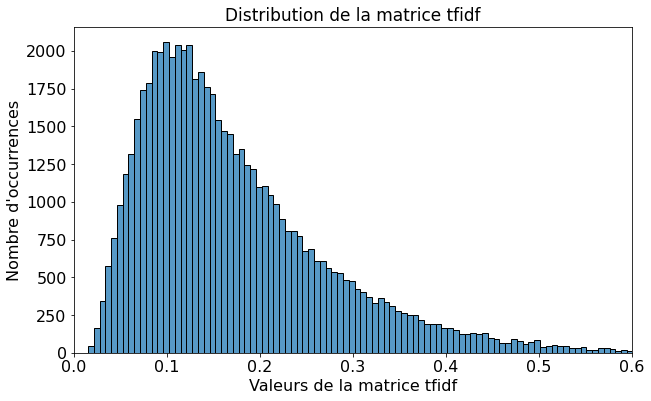

In [21]:
# Distribution des valeurs de la matrice tfidf
path = PureWindowsPath(os.getcwd() + "\\data\\output\\tfidf_distribution.png")
path = path.as_posix()

sb.histplot(X_train_tfidf.data, edgecolor="black", linewidth=1)
plt.xlabel("Valeurs de la matrice tfidf", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice tfidf", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

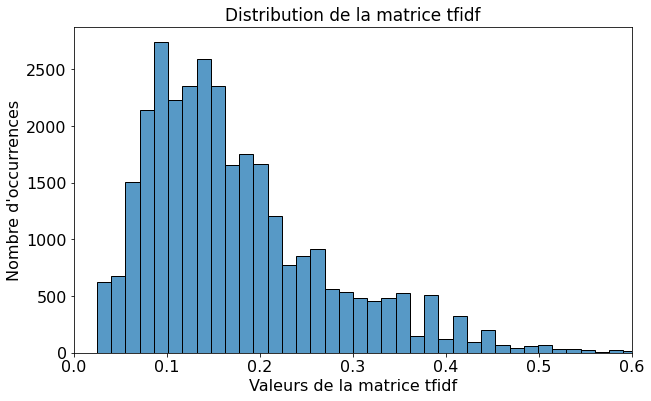

In [22]:
# Distribution des valeurs de la matrice hashing
path = PureWindowsPath(os.getcwd() + "\\data\\output\\tfidf_distribution.png")
path = path.as_posix()

sb.histplot(X_train_hashing.data, edgecolor="black", linewidth=1)
plt.xlabel("Valeurs de la matrice tfidf", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice tfidf", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

Text(0.5, 1.0, 'Distribution de la matrice tfidf')

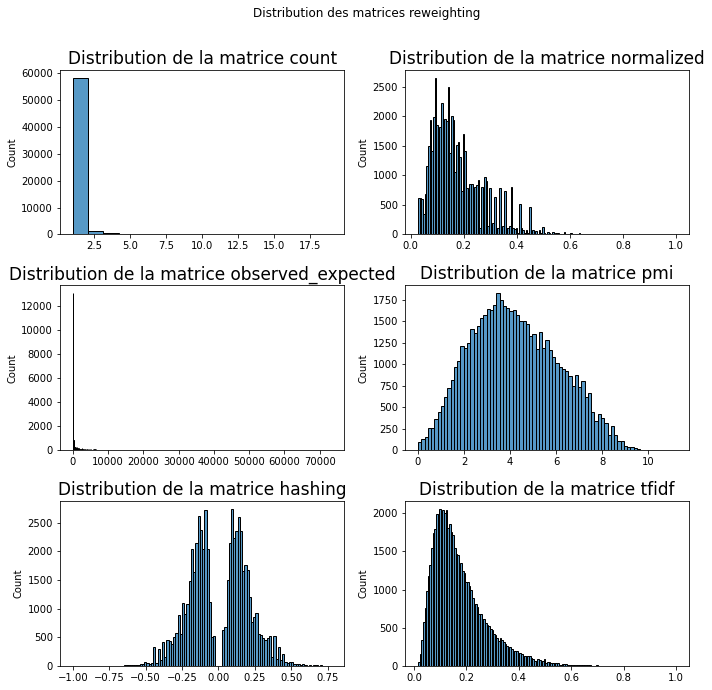

In [29]:
# Plot de toutes les distributions de matrices cote a cote
# Count, normalisation L2, expected observed, pmi, hashing, tfidf = 5 graphiques
fig, axes = plt.subplots(3, 2, figsize = (10, 10)) # Create a figure for 2 subplots (1 row, 2 columns)
fig.suptitle('Distribution des matrices reweighting')
fig.tight_layout(pad=3.0) #espace entre les graphiques

sb.histplot(X_train_count.data, edgecolor="black", linewidth=1, ax=axes[0,0])
axes[0,0].set_title("Distribution de la matrice count", size=17)

sb.histplot(X_train_normalized.data, edgecolor="black", linewidth=1, ax=axes[0,1])
axes[0,1].set_title("Distribution de la matrice normalized", size=17)

sb.histplot(np.ravel(X_train_observed_expected[X_train_observed_expected != 0]), edgecolor="black", linewidth=1, ax=axes[1,0])
axes[1,0].set_title("Distribution de la matrice observed_expected", size=17)

sb.histplot(np.ravel(X_train_pmi[X_train_pmi != 0]), edgecolor="black", linewidth=1, ax=axes[1,1])
axes[1,1].set_title("Distribution de la matrice pmi", size=17)

sb.histplot(X_train_hashing.data, edgecolor="black", linewidth=1, ax=axes[2,0])
axes[2,0].set_title("Distribution de la matrice hashing", size=17)

sb.histplot(X_train_tfidf.data, edgecolor="black", linewidth=1, ax=axes[2,1])
axes[2,1].set_title("Distribution de la matrice tfidf", size=17)

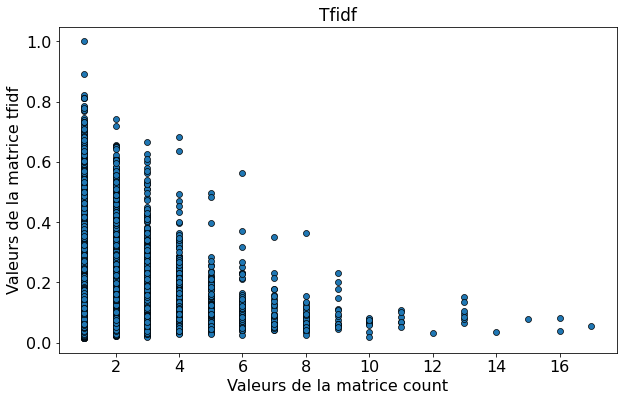

In [12]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice tfidf
path = PureWindowsPath(os.getcwd() + "\\data\\output\\tfidf_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=X_train_count.data, y=X_train_tfidf.data, edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice tfidf", size=16)
plt.title("Tfidf", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

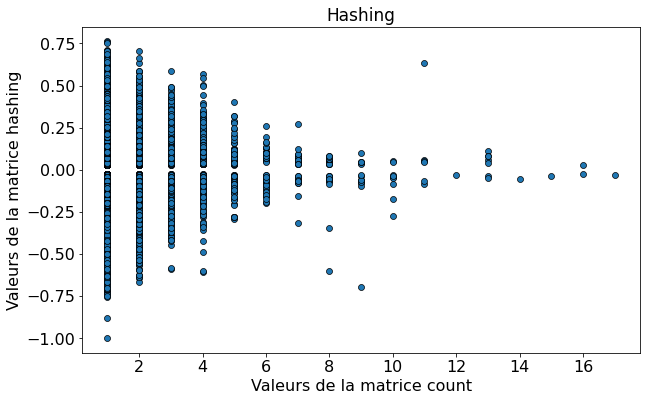

In [15]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice hashing
path = PureWindowsPath(os.getcwd() + "\\data\\output\\hashing_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=X_train_count.data, y=X_train_hashing.data, edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice hashing", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

In [ ]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice expected observed
path = PureWindowsPath(os.getcwd() + "\\data\\output\\hashing_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=X_train_count.data, y=np.ravel(X_train_observed_expected[X_train_observed_expected != 0]), 
                edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice hashing", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

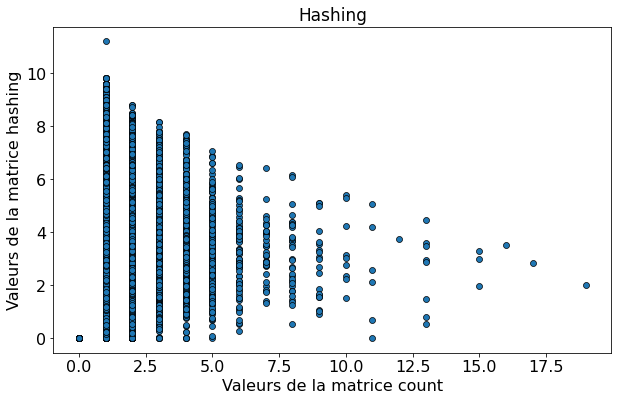

In [84]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice pmi
path = PureWindowsPath(os.getcwd() + "\\data\\output\\hashing_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=np.ravel(X_train_count.toarray()), y=np.ravel(X_train_pmi), edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice pmi", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

,0,1,2
0,1.031250,0.750000,1.145833
1,0.750000,1.090909,1.000000
2,1.178571,1.071429,0.916667
